In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# ------------------- Load and preprocess labels -------------------

# Load label files
main_labels = pd.read_csv('data_labels_mainData.csv')
extra_labels = pd.read_csv('data_labels_extraData.csv')
combined_labels = pd.concat([main_labels, extra_labels], ignore_index=True)

# Image folder
image_folder = "C:/Users/sweet/Downloads/Image_classification_data/patch_images"

# ------------------- Task 1: Cancerous classification -------------------

# Stratified splitting
train_labels_t1, temp_labels_t1 = train_test_split(
    combined_labels, test_size=0.3, random_state=42, stratify=combined_labels['isCancerous']
)
val_labels_t1, test_labels_t1 = train_test_split(
    temp_labels_t1, test_size=0.5, random_state=42, stratify=temp_labels_t1['isCancerous']
)

# Flow generators expect string labels
for df in [train_labels_t1, val_labels_t1, test_labels_t1]:
    df['isCancerous'] = df['isCancerous'].astype(str)

# ------------------- Task 2: Cell type classification -------------------

# Only use main_labels for this task
train_labels_t2, temp_labels_t2 = train_test_split(
    main_labels, test_size=0.3, random_state=42, stratify=main_labels['cellType']
)
val_labels_t2, test_labels_t2 = train_test_split(
    temp_labels_t2, test_size=0.5, random_state=42, stratify=temp_labels_t2['cellType']
)

# Convert cell type labels to string as well
for df in [train_labels_t2, val_labels_t2, test_labels_t2]:
    df['cellType'] = df['cellType'].astype(str)

# ------------------- Define ImageDataGenerators -------------------

# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalize
    # rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

# ------------------- Flow generators (Task 1) -------------------

train_gen_t1 = train_datagen.flow_from_dataframe(
    dataframe=train_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# ------------------- Flow generators (Task 2) -------------------

train_gen_t2 = train_datagen.flow_from_dataframe(
    dataframe=train_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
print(train_labels_t2['ImageName'].sample(5))
print(os.listdir(image_folder)[:5])

missing = [f for f in train_labels_t1['ImageName'] if not os.path.isfile(os.path.join(image_folder, f))]
print(f"Missing files: {len(missing)}")
print(missing[:10])

Found 1750 validated image filenames belonging to 2 classes.
Found 424 validated image filenames belonging to 2 classes.
Found 371 validated image filenames belonging to 2 classes.


C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 12446 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(
C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2618 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(
C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2671 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(


Found 868 validated image filenames belonging to 4 classes.
Found 190 validated image filenames belonging to 4 classes.
Found 177 validated image filenames belonging to 4 classes.


C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 6059 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(
C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1294 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(
C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1308 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(


1437     7863.png
8822    13912.png
4313    20142.png
322       140.png
85      18847.png
Name: ImageName, dtype: object
['10040.png', '10041.png', '10042.png', '10043.png', '10054.png']
Missing files: 12446
['15334.png', '20291.png', '5185.png', '3891.png', '9577.png', '15857.png', '17014.png', '1512.png', '14247.png', '16719.png']


In [7]:
# ------------------- Build and train CNN -------------------
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_t1), y=y_train_t1)
class_weights = dict(enumerate(class_weights))
print("📏 Class weights:", class_weights)

# Model definition
model_t1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_t1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images_t1)

# Train
history = model_t1.fit(
    datagen.flow(train_images_t1, y_train_t1, batch_size=32),
    validation_data=(val_images_t1, y_val_t1),
    epochs=20,
    class_weight=class_weights,
    verbose=1
)


NameError: name 'y_train_t1' is not defined

In [9]:
# ------------------- Evaluation -------------------

# Accuracy & Loss Plots
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

NameError: name 'history' is not defined

In [11]:
# Predictions
y_probs = (model_t1.predict(test_images_t1) >= 0.5).astype(int)


print(classification_report(y_test_t1, y_probs, target_names=["Not Cancerous", "Cancerous"]))

# Per-class bar plot
def plot_precision_recall_f1(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}

    plt.figure(figsize=(10, 5))
    for i, (metric, values) in enumerate(metrics.items()):
        plt.bar(np.arange(len(values)) + i*0.25, values, width=0.25, label=metric)
    
    plt.xticks(np.arange(len(class_names)) + 0.25, class_names)
    plt.ylim(0, 1.1)
    plt.ylabel("Score")
    plt.title("Per-Class Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_f1(y_test_t1, y_pred_final, ["Not Cancerous", "Cancerous"])

NameError: name 'model_t1' is not defined

In [2]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [13]:
import tensorflow as tf


model_t2_base = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # #VGG block 2
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    
    # #VGG block 3
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_t2_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [15]:
model_t2_base.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [17]:
history_t2_base = model_t2_base.fit(train_gen_t2, validation_data = val_gen_t2, epochs=50, verbose=1)

Epoch 1/50
28/28 [==============================] - 2s 38ms/step - loss: 1.2844 - categorical_accuracy: 0.4447 - val_loss: 1.2449 - val_categorical_accuracy: 0.4421
Epoch 2/50
28/28 [==============================] - 1s 32ms/step - loss: 1.1093 - categorical_accuracy: 0.5565 - val_loss: 1.2489 - val_categorical_accuracy: 0.4053
Epoch 3/50
28/28 [==============================] - 1s 34ms/step - loss: 0.9790 - categorical_accuracy: 0.5968 - val_loss: 0.9496 - val_categorical_accuracy: 0.5842
Epoch 4/50
28/28 [==============================] - 1s 33ms/step - loss: 0.8660 - categorical_accuracy: 0.6694 - val_loss: 0.8942 - val_categorical_accuracy: 0.6684
Epoch 5/50
28/28 [==============================] - 1s 33ms/step - loss: 0.8343 - categorical_accuracy: 0.6671 - val_loss: 1.1009 - val_categorical_accuracy: 0.5421
Epoch 6/50
28/28 [==============================] - 1s 33ms/step - loss: 0.7758 - categorical_accuracy: 0.6970 - val_loss: 0.8022 - val_categorical_accuracy: 0.6842
Epoch 7/50

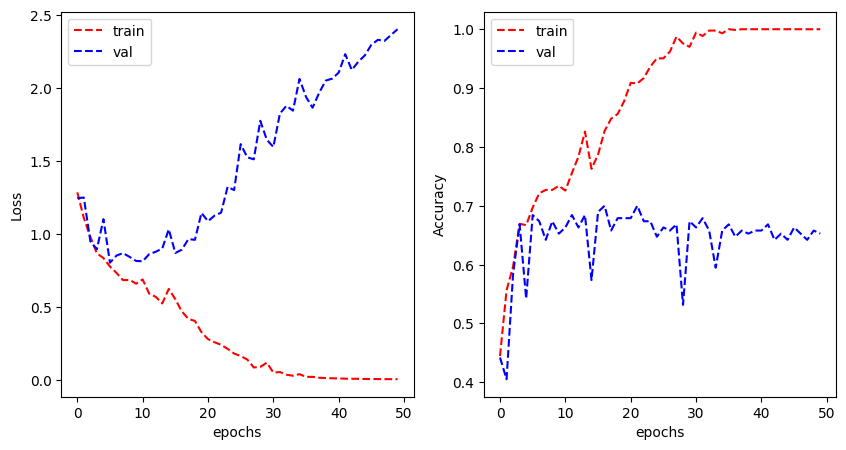

6/6 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        42
           1       0.59      0.66      0.62        35
           2       0.78      0.90      0.83        70
           3       0.50      0.20      0.29        30

    accuracy                           0.67       177
   macro avg       0.62      0.60      0.59       177
weighted avg       0.65      0.67      0.65       177



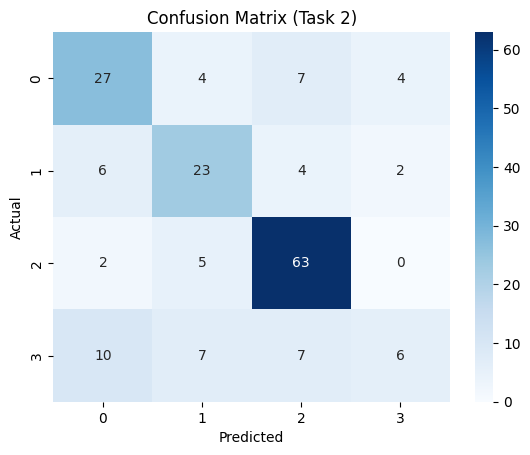

In [19]:
plot_learning_curve(history_t2_base.history['loss'], history_t2_base.history['val_loss'], 
                    history_t2_base.history['categorical_accuracy'], history_t2_base.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
y_probs_t2_base = model_t2_base.predict(test_gen_t2, verbose=1)
y_pred_final_t2_base = np.argmax(y_probs_t2_base, axis=1)
print(classification_report(test_gen_t2.labels, y_pred_final_t2_base, target_names=["0", "1", "2", "3"]))
cm_t2_base = confusion_matrix(test_gen_t2.labels, y_pred_final_t2_base)
sns.heatmap(cm_t2_base, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1", "2", "3"], yticklabels=["0", "1", "2", "3"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 2)")
plt.show()

In [285]:
reg_lambda = 0.001

train_datagen = ImageDataGenerator( rescale=1./255,
                                   rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32


model_t2 = tf.keras.Sequential([
    # VGG Block 1
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG Block 2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG Block 3
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fully Connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])
model_t2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_91 (Ba  (None, 27, 27, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_91 (Activation)  (None, 27, 27, 32)        0         
                                                                 
 conv2d_100 (Conv2D)         (None, 27, 27, 32)        9248      
                                                                 
 batch_normalization_92 (Ba  (None, 27, 27, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_92 (Activation)  (None, 27, 27, 32)      

In [287]:
model_t2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Example for 4 classes (0, 1, 2, 3)
y_int = train_labels_t2['cellType'].astype(int)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_int),
    y=y_int
)

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights_array))


In [289]:
model_t2.fit(
    train_gen_t2,
    validation_data=val_gen_t2,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
28/28 [==============================] - 7s 137ms/step - loss: 2.2223 - categorical_accuracy: 0.4124 - val_loss: 2.1550 - val_categorical_accuracy: 0.4421 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 4s 124ms/step - loss: 1.9173 - categorical_accuracy: 0.5611 - val_loss: 2.1103 - val_categorical_accuracy: 0.4421 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 3s 120ms/step - loss: 1.7722 - categorical_accuracy: 0.6198 - val_loss: 2.2212 - val_categorical_accuracy: 0.5105 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 4s 125ms/step - loss: 1.7700 - categorical_accuracy: 0.5979 - val_loss: 2.9634 - val_categorical_accuracy: 0.4421 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - ETA: 0s - loss: 1.6354 - categorical_accuracy: 0.6843
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 4s 131ms/step - loss: 1.6354 - categorical_accuracy: 0.6

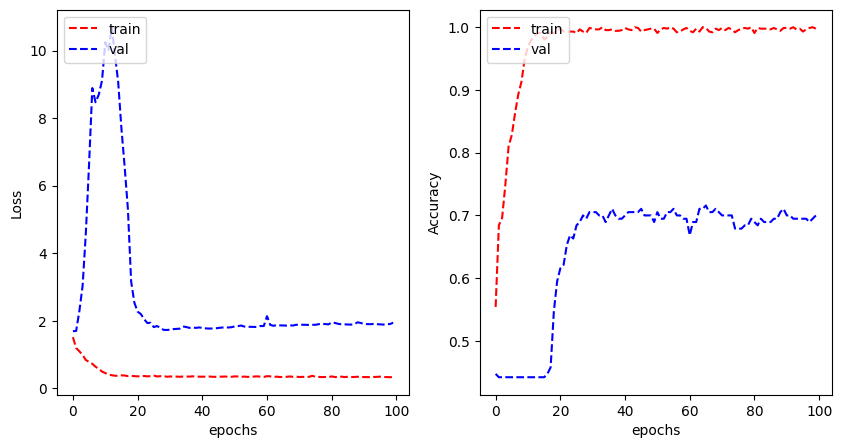

In [281]:
plot_learning_curve(history_t2.history['loss'], history_t2.history['val_loss'], 
                    history_t2.history['categorical_accuracy'], history_t2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

6/6 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        42
           1       0.61      0.80      0.69        35
           2       0.87      0.84      0.86        70
           3       0.62      0.27      0.37        30

    accuracy                           0.72       177
   macro avg       0.69      0.67      0.66       177
weighted avg       0.72      0.72      0.71       177



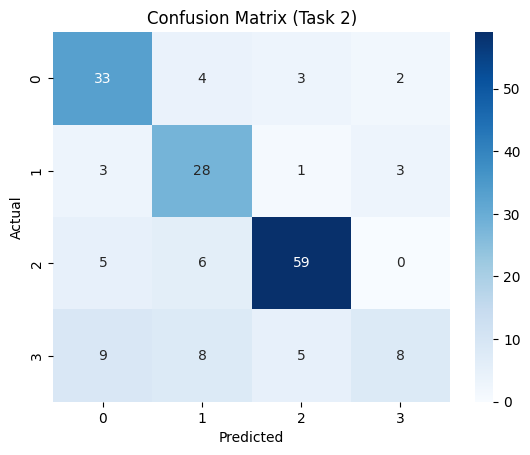

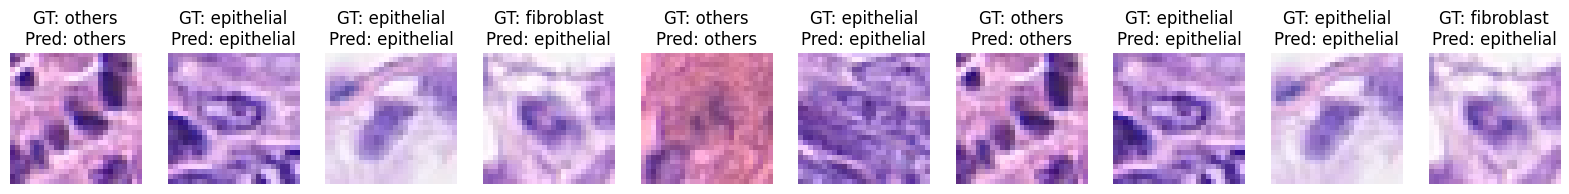

In [283]:
y_probs_t2 = model_t2.predict(test_gen_t2, verbose=1)
y_pred_final_t2 = np.argmax(y_probs_t2, axis=1)
print(classification_report(test_gen_t2.labels, y_pred_final_t2, target_names=["0", "1", "2", "3"]))
cm_t2 = confusion_matrix(test_gen_t2.labels, y_pred_final_t2)
sns.heatmap(cm_t2, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1", "2", "3"], yticklabels=["0", "1", "2", "3"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 2)")
plt.show()

label_names = {'fibroblast': 0, 'inflammatory': 1, 'epithelial': 2, 'others': 3}
d_inv = {v: k for k, v in label_names.items()}

plt.figure(figsize=(20, 6))
batches = 0

for x, y in test_gen_t2:
    batches += 1
    y_hat = model_t2.predict(x, verbose=0)

    if batches <= 10:
        image = x[0]
        label = y[0]
        pred = y_hat[0]

        plt.subplot(1, 10, batches)
        plt.imshow(image)
        plt.title(f"GT: {d_inv[np.argmax(label)]}\nPred: {d_inv[np.argmax(pred)]}")
        plt.axis('off')
    else:
        break
